In [1]:
import numpy as np
import pickle
from pandas import DataFrame, read_csv
from sklearn import preprocessing
from sklearn import metrics as met
import warnings
import tensorflow as tf
from tensorflow.contrib import rnn
import helperModule as hm
import matplotlib.pyplot as plt
from tensorflow import nn
from matplotlib import gridspec

warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'



In [9]:
#########################
############ Hyperparamter
#########################

st_dev = 0.2
learning_rate = 0.005
training_iters = 92000000
batch_size = 128
display_step = 100
display_testing_step = 400
dropout_rate = 0.5

n_input = 41 # Number of features
n_steps = 1 # timesteps
n_hidden = 96 # hidden layer num of nodes
n_classes = 5 # KDD99 total classes ( Normal + 4 attack types)


In [10]:
#########################
############ Read in data
#########################

data = pickle.load( open( "kdd99.p", "rb" ) )

x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']


In [11]:
tf.reset_default_graph()

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# Define weights
W = {
    'out': tf.Variable(tf.truncated_normal([n_hidden, n_classes], stddev=st_dev))
}

b = {
    'out': tf.Variable(tf.zeros([n_classes]))
}

In [12]:
num_layers = 2

def RNN(x, W, b):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, n_steps, 1)

    # Define a lstm cell with tensorflow
    #with tf.variable_scope('lstm_cell_def'):

        #lstm_cell = tf.contrib.rnn.LSTMCell(n_hidden, state_is_tuple = True)
        #lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, input_keep_prob=keep_prob)  
    stacked_rnn = []
    for i in range(num_layers):
        stacked_rnn.append(tf.contrib.rnn.DropoutWrapper(tf.nn.rnn_cell.LSTMCell(n_hidden, state_is_tuple=True), input_keep_prob=keep_prob)) 
    

    lstm_cell = tf.contrib.rnn.MultiRNNCell(stacked_rnn)
        #lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, input_keep_prob=keep_prob)
                
        
    output, states = tf.nn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(output[-1], W['out']) + b['out']



In [13]:

pred = RNN(x, W, b)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


In [14]:
# Initializing the variables
init = tf.global_variables_initializer()


In [15]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    losses = {'train':[], 'validation':[]}
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        offset_val = (step * batch_size) % (y_test.shape[0] - batch_size)
        
        # Generate minibatches for training and validating.
        batch_x = x_train[offset:(offset + batch_size), :]
        batch_y = y_train[offset:(offset + batch_size), :]
        batch_val_x = x_test[offset_val:(offset_val + batch_size), :]
        batch_val_y = y_test[offset_val:(offset_val + batch_size), :]
        
        # Reshape data to feed into RNN
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        batch_val_x = batch_val_x.reshape((batch_size, n_steps, n_input))
        
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob:dropout_rate})
        loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y, keep_prob:dropout_rate})
        loss_test = sess.run(cost, feed_dict={x: batch_val_x, y: batch_val_y, keep_prob:dropout_rate})

        if step % display_step == 0:

            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + "{:.6f}".format(loss) +  ", Minibatch Val Loss= " + \
                  "{:.6f}".format(loss_test)
                        
        losses['train'].append(loss)
        losses['validation'].append(loss_test)
        step += 1
            
    print("Optimization Finished!")

    y_pred = sess.run(tf.argmax(pred, 1), feed_dict={x:x_test.reshape((-1, n_steps, n_input)), keep_prob:1.0})
    y_true = np.argmax(y_test,1)
    conf_matrix = met.confusion_matrix(y_true, y_pred)
    
    

Iter 12800, Minibatch Loss= 1.587587, Minibatch Val Loss= 0.234640
Iter 25600, Minibatch Loss= 0.027938, Minibatch Val Loss= 2.341515
Iter 38400, Minibatch Loss= 0.008187, Minibatch Val Loss= 0.802788
Iter 51200, Minibatch Loss= 0.285223, Minibatch Val Loss= 0.012571
Iter 64000, Minibatch Loss= 0.012165, Minibatch Val Loss= 0.145447
Iter 76800, Minibatch Loss= 0.635972, Minibatch Val Loss= 0.753968
Iter 89600, Minibatch Loss= 0.046657, Minibatch Val Loss= 1.915457
Iter 102400, Minibatch Loss= 0.014343, Minibatch Val Loss= 2.783778
Iter 115200, Minibatch Loss= 0.006774, Minibatch Val Loss= 2.365669
Iter 128000, Minibatch Loss= 0.006860, Minibatch Val Loss= 1.708799
Iter 140800, Minibatch Loss= 1.559187, Minibatch Val Loss= 4.797357
Iter 153600, Minibatch Loss= 0.078625, Minibatch Val Loss= 0.724807
Iter 166400, Minibatch Loss= 0.011069, Minibatch Val Loss= 3.719857
Iter 179200, Minibatch Loss= 0.001097, Minibatch Val Loss= 0.002662
Iter 192000, Minibatch Loss= 0.001012, Minibatch Val Lo

Iter 1548800, Minibatch Loss= 0.024746, Minibatch Val Loss= 0.027895
Iter 1561600, Minibatch Loss= 0.054366, Minibatch Val Loss= 0.552667
Iter 1574400, Minibatch Loss= 0.575192, Minibatch Val Loss= 0.690604
Iter 1587200, Minibatch Loss= 0.166540, Minibatch Val Loss= 0.197669
Iter 1600000, Minibatch Loss= 0.019106, Minibatch Val Loss= 0.274219
Iter 1612800, Minibatch Loss= 0.103429, Minibatch Val Loss= 0.086475
Iter 1625600, Minibatch Loss= 0.308056, Minibatch Val Loss= 0.462848
Iter 1638400, Minibatch Loss= 0.023899, Minibatch Val Loss= 0.022716
Iter 1651200, Minibatch Loss= 0.001199, Minibatch Val Loss= 5.224631
Iter 1664000, Minibatch Loss= 0.000197, Minibatch Val Loss= 2.690949
Iter 1676800, Minibatch Loss= 0.000197, Minibatch Val Loss= 2.431960
Iter 1689600, Minibatch Loss= 0.000220, Minibatch Val Loss= 4.149521
Iter 1702400, Minibatch Loss= 0.000243, Minibatch Val Loss= 2.992104
Iter 1715200, Minibatch Loss= 0.000320, Minibatch Val Loss= 2.638913
Iter 1728000, Minibatch Loss= 0.00

Iter 3072000, Minibatch Loss= 0.067797, Minibatch Val Loss= 0.190013
Iter 3084800, Minibatch Loss= 0.013689, Minibatch Val Loss= 1.033083
Iter 3097600, Minibatch Loss= 0.024133, Minibatch Val Loss= 0.002291
Iter 3110400, Minibatch Loss= 0.839582, Minibatch Val Loss= 0.212379
Iter 3123200, Minibatch Loss= 0.044555, Minibatch Val Loss= 0.067505
Iter 3136000, Minibatch Loss= 0.009707, Minibatch Val Loss= 0.008737
Iter 3148800, Minibatch Loss= 0.002561, Minibatch Val Loss= 1.725270
Iter 3161600, Minibatch Loss= 0.003341, Minibatch Val Loss= 0.001575
Iter 3174400, Minibatch Loss= 0.000775, Minibatch Val Loss= 0.001745
Iter 3187200, Minibatch Loss= 0.000946, Minibatch Val Loss= 1.951916
Iter 3200000, Minibatch Loss= 0.000800, Minibatch Val Loss= 2.452407
Iter 3212800, Minibatch Loss= 0.000624, Minibatch Val Loss= 3.457741
Iter 3225600, Minibatch Loss= 0.001079, Minibatch Val Loss= 3.378795
Iter 3238400, Minibatch Loss= 0.000624, Minibatch Val Loss= 1.419609
Iter 3251200, Minibatch Loss= 0.00

Iter 4595200, Minibatch Loss= 0.371030, Minibatch Val Loss= 0.287445
Iter 4608000, Minibatch Loss= 0.020209, Minibatch Val Loss= 0.024860
Iter 4620800, Minibatch Loss= 0.002018, Minibatch Val Loss= 0.005333
Iter 4633600, Minibatch Loss= 0.002302, Minibatch Val Loss= 0.001463
Iter 4646400, Minibatch Loss= 0.003365, Minibatch Val Loss= 0.008896
Iter 4659200, Minibatch Loss= 0.000535, Minibatch Val Loss= 0.004988
Iter 4672000, Minibatch Loss= 0.000207, Minibatch Val Loss= 3.221889
Iter 4684800, Minibatch Loss= 0.000498, Minibatch Val Loss= 0.000321
Iter 4697600, Minibatch Loss= 0.000450, Minibatch Val Loss= 0.000321
Iter 4710400, Minibatch Loss= 0.000237, Minibatch Val Loss= 0.000180
Iter 4723200, Minibatch Loss= 0.000163, Minibatch Val Loss= 0.000373
Iter 4736000, Minibatch Loss= 0.000100, Minibatch Val Loss= 0.000192
Iter 4748800, Minibatch Loss= 0.000108, Minibatch Val Loss= 0.000099
Iter 4761600, Minibatch Loss= 0.000066, Minibatch Val Loss= 5.800542
Iter 4774400, Minibatch Loss= 0.00

Iter 6118400, Minibatch Loss= 0.003411, Minibatch Val Loss= 1.014045
Iter 6131200, Minibatch Loss= 0.001896, Minibatch Val Loss= 0.002682
Iter 6144000, Minibatch Loss= 0.000558, Minibatch Val Loss= 0.000713
Iter 6156800, Minibatch Loss= 0.001334, Minibatch Val Loss= 0.000835
Iter 6169600, Minibatch Loss= 0.000303, Minibatch Val Loss= 0.000418
Iter 6182400, Minibatch Loss= 0.000357, Minibatch Val Loss= 0.000787
Iter 6195200, Minibatch Loss= 0.000492, Minibatch Val Loss= 2.345194
Iter 6208000, Minibatch Loss= 0.000669, Minibatch Val Loss= 0.014050
Iter 6220800, Minibatch Loss= 0.000229, Minibatch Val Loss= 0.000157
Iter 6233600, Minibatch Loss= 0.000124, Minibatch Val Loss= 0.000180
Iter 6246400, Minibatch Loss= 0.000240, Minibatch Val Loss= 0.000130
Iter 6259200, Minibatch Loss= 0.000221, Minibatch Val Loss= 4.966454
Iter 6272000, Minibatch Loss= 0.226528, Minibatch Val Loss= 0.128298
Iter 6284800, Minibatch Loss= 0.004066, Minibatch Val Loss= 0.511176
Iter 6297600, Minibatch Loss= 0.23

Iter 7641600, Minibatch Loss= 0.000140, Minibatch Val Loss= 0.187100
Iter 7654400, Minibatch Loss= 0.000188, Minibatch Val Loss= 0.133528
Iter 7667200, Minibatch Loss= 0.000167, Minibatch Val Loss= 0.138156
Iter 7680000, Minibatch Loss= 0.000132, Minibatch Val Loss= 0.000129
Iter 7692800, Minibatch Loss= 0.000199, Minibatch Val Loss= 2.796447
Iter 7705600, Minibatch Loss= 0.000092, Minibatch Val Loss= 0.000199
Iter 7718400, Minibatch Loss= 0.000066, Minibatch Val Loss= 0.000094
Iter 7731200, Minibatch Loss= 0.000142, Minibatch Val Loss= 0.000139
Iter 7744000, Minibatch Loss= 0.001328, Minibatch Val Loss= 4.222142
Iter 7756800, Minibatch Loss= 0.084574, Minibatch Val Loss= 0.036689
Iter 7769600, Minibatch Loss= 0.013015, Minibatch Val Loss= 0.000064
Iter 7782400, Minibatch Loss= 0.002772, Minibatch Val Loss= 0.179087
Iter 7795200, Minibatch Loss= 0.005955, Minibatch Val Loss= 0.154330
Iter 7808000, Minibatch Loss= 0.093037, Minibatch Val Loss= 1.365272
Iter 7820800, Minibatch Loss= 0.01

Iter 9164800, Minibatch Loss= 0.000346, Minibatch Val Loss= 1.279454
Iter 9177600, Minibatch Loss= 0.000209, Minibatch Val Loss= 1.511380
Iter 9190400, Minibatch Loss= 0.000255, Minibatch Val Loss= 1.288448
Iter 9203200, Minibatch Loss= 0.000284, Minibatch Val Loss= 0.370662
Iter 9216000, Minibatch Loss= 0.000550, Minibatch Val Loss= 0.375935
Iter 9228800, Minibatch Loss= 0.000084, Minibatch Val Loss= 1.134223
Iter 9241600, Minibatch Loss= 0.084784, Minibatch Val Loss= 0.308278
Iter 9254400, Minibatch Loss= 0.000705, Minibatch Val Loss= 0.161674
Iter 9267200, Minibatch Loss= 0.008396, Minibatch Val Loss= 0.075516
Iter 9280000, Minibatch Loss= 0.000740, Minibatch Val Loss= 0.092733
Iter 9292800, Minibatch Loss= 0.026515, Minibatch Val Loss= 0.021872
Iter 9305600, Minibatch Loss= 0.003829, Minibatch Val Loss= 2.320743
Iter 9318400, Minibatch Loss= 0.001098, Minibatch Val Loss= 0.000013
Iter 9331200, Minibatch Loss= 0.000442, Minibatch Val Loss= 0.000692
Iter 9344000, Minibatch Loss= 0.11

Iter 10675200, Minibatch Loss= 0.000309, Minibatch Val Loss= 2.148771
Iter 10688000, Minibatch Loss= 0.000100, Minibatch Val Loss= 1.183082
Iter 10700800, Minibatch Loss= 0.000050, Minibatch Val Loss= 2.800470
Iter 10713600, Minibatch Loss= 0.000109, Minibatch Val Loss= 7.063055
Iter 10726400, Minibatch Loss= 0.003106, Minibatch Val Loss= 0.111022
Iter 10739200, Minibatch Loss= 0.000025, Minibatch Val Loss= 1.067099
Iter 10752000, Minibatch Loss= 0.002468, Minibatch Val Loss= 0.654784
Iter 10764800, Minibatch Loss= 0.000309, Minibatch Val Loss= 0.381335
Iter 10777600, Minibatch Loss= 0.017045, Minibatch Val Loss= 0.086400
Iter 10790400, Minibatch Loss= 0.003268, Minibatch Val Loss= 0.006858
Iter 10803200, Minibatch Loss= 0.001216, Minibatch Val Loss= 3.894167
Iter 10816000, Minibatch Loss= 0.001017, Minibatch Val Loss= 0.001634
Iter 10828800, Minibatch Loss= 0.025959, Minibatch Val Loss= 0.356514
Iter 10841600, Minibatch Loss= 0.003243, Minibatch Val Loss= 0.348519
Iter 10854400, Minib

Iter 12185600, Minibatch Loss= 0.000048, Minibatch Val Loss= 0.000050
Iter 12198400, Minibatch Loss= 0.405024, Minibatch Val Loss= 0.024120
Iter 12211200, Minibatch Loss= 0.022436, Minibatch Val Loss= 0.282429
Iter 12224000, Minibatch Loss= 0.291603, Minibatch Val Loss= 1.481724
Iter 12236800, Minibatch Loss= 0.000313, Minibatch Val Loss= 0.226860
Iter 12249600, Minibatch Loss= 0.000131, Minibatch Val Loss= 1.223298
Iter 12262400, Minibatch Loss= 0.004839, Minibatch Val Loss= 2.695507
Iter 12275200, Minibatch Loss= 0.002252, Minibatch Val Loss= 1.248956
Iter 12288000, Minibatch Loss= 0.001448, Minibatch Val Loss= 0.269924
Iter 12300800, Minibatch Loss= 0.000443, Minibatch Val Loss= 0.117410
Iter 12313600, Minibatch Loss= 0.409810, Minibatch Val Loss= 1.856196
Iter 12326400, Minibatch Loss= 0.001861, Minibatch Val Loss= 1.436279
Iter 12339200, Minibatch Loss= 0.025508, Minibatch Val Loss= 0.183459
Iter 12352000, Minibatch Loss= 0.023386, Minibatch Val Loss= 0.059564
Iter 12364800, Minib

Iter 13696000, Minibatch Loss= 0.008475, Minibatch Val Loss= 0.344263
Iter 13708800, Minibatch Loss= 0.001291, Minibatch Val Loss= 0.143675
Iter 13721600, Minibatch Loss= 0.000214, Minibatch Val Loss= 0.157393
Iter 13734400, Minibatch Loss= 0.052054, Minibatch Val Loss= 0.071548
Iter 13747200, Minibatch Loss= 0.007421, Minibatch Val Loss= 0.003022
Iter 13760000, Minibatch Loss= 0.002459, Minibatch Val Loss= 0.979770
Iter 13772800, Minibatch Loss= 0.001111, Minibatch Val Loss= 2.116081
Iter 13785600, Minibatch Loss= 0.992965, Minibatch Val Loss= 0.193857
Iter 13798400, Minibatch Loss= 0.015753, Minibatch Val Loss= 0.004262
Iter 13811200, Minibatch Loss= 0.007669, Minibatch Val Loss= 6.868877
Iter 13824000, Minibatch Loss= 0.158925, Minibatch Val Loss= 2.983744
Iter 13836800, Minibatch Loss= 0.228919, Minibatch Val Loss= 0.034387
Iter 13849600, Minibatch Loss= 0.021857, Minibatch Val Loss= 0.003788
Iter 13862400, Minibatch Loss= 0.008961, Minibatch Val Loss= 2.249239
Iter 13875200, Minib

Iter 15206400, Minibatch Loss= 0.000424, Minibatch Val Loss= 2.992153
Iter 15219200, Minibatch Loss= 0.024675, Minibatch Val Loss= 0.003930
Iter 15232000, Minibatch Loss= 0.002031, Minibatch Val Loss= 0.000035
Iter 15244800, Minibatch Loss= 0.000872, Minibatch Val Loss= 0.000756
Iter 15257600, Minibatch Loss= 0.000308, Minibatch Val Loss= 0.000866
Iter 15270400, Minibatch Loss= 0.066350, Minibatch Val Loss= 1.242884
Iter 15283200, Minibatch Loss= 0.020399, Minibatch Val Loss= 0.485928
Iter 15296000, Minibatch Loss= 0.000902, Minibatch Val Loss= 0.244653
Iter 15308800, Minibatch Loss= 0.098657, Minibatch Val Loss= 0.365065
Iter 15321600, Minibatch Loss= 0.066424, Minibatch Val Loss= 0.052561
Iter 15334400, Minibatch Loss= 0.008428, Minibatch Val Loss= 1.356176
Iter 15347200, Minibatch Loss= 0.001928, Minibatch Val Loss= 0.063250
Iter 15360000, Minibatch Loss= 0.043691, Minibatch Val Loss= 1.379348
Iter 15372800, Minibatch Loss= 0.001118, Minibatch Val Loss= 4.643185
Iter 15385600, Minib

Iter 16716800, Minibatch Loss= 0.002484, Minibatch Val Loss= 0.001134
Iter 16729600, Minibatch Loss= 0.001363, Minibatch Val Loss= 0.006942
Iter 16742400, Minibatch Loss= 0.000821, Minibatch Val Loss= 0.000717
Iter 16755200, Minibatch Loss= 0.020346, Minibatch Val Loss= 0.280810
Iter 16768000, Minibatch Loss= 0.002537, Minibatch Val Loss= 0.700355
Iter 16780800, Minibatch Loss= 0.041606, Minibatch Val Loss= 0.037236
Iter 16793600, Minibatch Loss= 0.026962, Minibatch Val Loss= 0.060989
Iter 16806400, Minibatch Loss= 0.016578, Minibatch Val Loss= 0.065061
Iter 16819200, Minibatch Loss= 0.015747, Minibatch Val Loss= 0.095363
Iter 16832000, Minibatch Loss= 1.224082, Minibatch Val Loss= 0.374222
Iter 16844800, Minibatch Loss= 1.368241, Minibatch Val Loss= 0.020253
Iter 16857600, Minibatch Loss= 0.000783, Minibatch Val Loss= 0.047680
Iter 16870400, Minibatch Loss= 0.134099, Minibatch Val Loss= 1.539572
Iter 16883200, Minibatch Loss= 0.069229, Minibatch Val Loss= 1.449546
Iter 16896000, Minib

Iter 18227200, Minibatch Loss= 0.000727, Minibatch Val Loss= 0.061856
Iter 18240000, Minibatch Loss= 0.510773, Minibatch Val Loss= 1.772147
Iter 18252800, Minibatch Loss= 0.011558, Minibatch Val Loss= 0.473084
Iter 18265600, Minibatch Loss= 0.018598, Minibatch Val Loss= 2.740290
Iter 18278400, Minibatch Loss= 0.021775, Minibatch Val Loss= 0.177982
Iter 18291200, Minibatch Loss= 0.021367, Minibatch Val Loss= 0.080139
Iter 18304000, Minibatch Loss= 0.004469, Minibatch Val Loss= 0.230035
Iter 18316800, Minibatch Loss= 0.347185, Minibatch Val Loss= 0.205564
Iter 18329600, Minibatch Loss= 0.012617, Minibatch Val Loss= 0.005721
Iter 18342400, Minibatch Loss= 0.011267, Minibatch Val Loss= 1.534774
Iter 18355200, Minibatch Loss= 0.043462, Minibatch Val Loss= 0.223222
Iter 18368000, Minibatch Loss= 0.119406, Minibatch Val Loss= 0.113429
Iter 18380800, Minibatch Loss= 0.035284, Minibatch Val Loss= 0.291192
Iter 18393600, Minibatch Loss= 0.005404, Minibatch Val Loss= 0.064410
Iter 18406400, Minib

Iter 19737600, Minibatch Loss= 0.019788, Minibatch Val Loss= 0.088086
Iter 19750400, Minibatch Loss= 0.170458, Minibatch Val Loss= 0.025906
Iter 19763200, Minibatch Loss= 0.108961, Minibatch Val Loss= 0.015687
Iter 19776000, Minibatch Loss= 0.017043, Minibatch Val Loss= 0.896441
Iter 19788800, Minibatch Loss= 0.008246, Minibatch Val Loss= 1.780578
Iter 19801600, Minibatch Loss= 0.047417, Minibatch Val Loss= 0.327030
Iter 19814400, Minibatch Loss= 0.013633, Minibatch Val Loss= 3.366245
Iter 19827200, Minibatch Loss= 0.000449, Minibatch Val Loss= 0.032239
Iter 19840000, Minibatch Loss= 0.037343, Minibatch Val Loss= 0.318670
Iter 19852800, Minibatch Loss= 0.028717, Minibatch Val Loss= 0.047663
Iter 19865600, Minibatch Loss= 0.008665, Minibatch Val Loss= 0.047580
Iter 19878400, Minibatch Loss= 0.000201, Minibatch Val Loss= 1.551928
Iter 19891200, Minibatch Loss= 0.022489, Minibatch Val Loss= 0.000303
Iter 19904000, Minibatch Loss= 0.061070, Minibatch Val Loss= 0.292847
Iter 19916800, Minib

Iter 21248000, Minibatch Loss= 0.038703, Minibatch Val Loss= 0.077789
Iter 21260800, Minibatch Loss= 0.020152, Minibatch Val Loss= 0.019162
Iter 21273600, Minibatch Loss= 0.006791, Minibatch Val Loss= 8.132303
Iter 21286400, Minibatch Loss= 0.035196, Minibatch Val Loss= 0.485554
Iter 21299200, Minibatch Loss= 0.006603, Minibatch Val Loss= 0.038093
Iter 21312000, Minibatch Loss= 0.312835, Minibatch Val Loss= 0.029541
Iter 21324800, Minibatch Loss= 0.019755, Minibatch Val Loss= 2.298212
Iter 21337600, Minibatch Loss= 0.020618, Minibatch Val Loss= 1.136300
Iter 21350400, Minibatch Loss= 0.003894, Minibatch Val Loss= 1.293592
Iter 21363200, Minibatch Loss= 0.000549, Minibatch Val Loss= 0.070424
Iter 21376000, Minibatch Loss= 0.096112, Minibatch Val Loss= 0.011834
Iter 21388800, Minibatch Loss= 0.203120, Minibatch Val Loss= 0.135734
Iter 21401600, Minibatch Loss= 0.006515, Minibatch Val Loss= 0.008339
Iter 21414400, Minibatch Loss= 0.006686, Minibatch Val Loss= 0.002454
Iter 21427200, Minib

Iter 22758400, Minibatch Loss= 0.077763, Minibatch Val Loss= 0.387623
Iter 22771200, Minibatch Loss= 1.321859, Minibatch Val Loss= 4.744825
Iter 22784000, Minibatch Loss= 0.002570, Minibatch Val Loss= 0.044800
Iter 22796800, Minibatch Loss= 0.087406, Minibatch Val Loss= 0.842067
Iter 22809600, Minibatch Loss= 0.013623, Minibatch Val Loss= 0.239370
Iter 22822400, Minibatch Loss= 0.007765, Minibatch Val Loss= 3.490152
Iter 22835200, Minibatch Loss= 0.031403, Minibatch Val Loss= 5.679785
Iter 22848000, Minibatch Loss= 0.070115, Minibatch Val Loss= 0.031453
Iter 22860800, Minibatch Loss= 0.306968, Minibatch Val Loss= 0.852704
Iter 22873600, Minibatch Loss= 0.027002, Minibatch Val Loss= 0.490551
Iter 22886400, Minibatch Loss= 0.002035, Minibatch Val Loss= 0.876452
Iter 22899200, Minibatch Loss= 0.001481, Minibatch Val Loss= 0.589325
Iter 22912000, Minibatch Loss= 0.000853, Minibatch Val Loss= 0.001027
Iter 22924800, Minibatch Loss= 0.000142, Minibatch Val Loss= 3.397207
Iter 22937600, Minib

Iter 24268800, Minibatch Loss= 0.001078, Minibatch Val Loss= 0.045659
Iter 24281600, Minibatch Loss= 0.043699, Minibatch Val Loss= 0.292083
Iter 24294400, Minibatch Loss= 0.271689, Minibatch Val Loss= 0.125253
Iter 24307200, Minibatch Loss= 0.028824, Minibatch Val Loss= 0.032840
Iter 24320000, Minibatch Loss= 0.001455, Minibatch Val Loss= 0.078221
Iter 24332800, Minibatch Loss= 0.022774, Minibatch Val Loss= 2.612003
Iter 24345600, Minibatch Loss= 0.200804, Minibatch Val Loss= 0.742332
Iter 24358400, Minibatch Loss= 0.007774, Minibatch Val Loss= 2.493047
Iter 24371200, Minibatch Loss= 0.002366, Minibatch Val Loss= 1.332612
Iter 24384000, Minibatch Loss= 0.001674, Minibatch Val Loss= 3.664788
Iter 24396800, Minibatch Loss= 0.000919, Minibatch Val Loss= 0.483968
Iter 24409600, Minibatch Loss= 0.001473, Minibatch Val Loss= 1.164951
Iter 24422400, Minibatch Loss= 0.000405, Minibatch Val Loss= 0.850590
Iter 24435200, Minibatch Loss= 0.000217, Minibatch Val Loss= 0.625200
Iter 24448000, Minib

Iter 25779200, Minibatch Loss= 0.029940, Minibatch Val Loss= 2.670573
Iter 25792000, Minibatch Loss= 0.008437, Minibatch Val Loss= 0.004247
Iter 25804800, Minibatch Loss= 0.000889, Minibatch Val Loss= 1.616045
Iter 25817600, Minibatch Loss= 0.007181, Minibatch Val Loss= 0.010623
Iter 25830400, Minibatch Loss= 0.314182, Minibatch Val Loss= 0.144358
Iter 25843200, Minibatch Loss= 0.011056, Minibatch Val Loss= 0.771446
Iter 25856000, Minibatch Loss= 0.002329, Minibatch Val Loss= 0.004049
Iter 25868800, Minibatch Loss= 0.002364, Minibatch Val Loss= 0.001526
Iter 25881600, Minibatch Loss= 0.003388, Minibatch Val Loss= 0.469768
Iter 25894400, Minibatch Loss= 0.000536, Minibatch Val Loss= 2.493806
Iter 25907200, Minibatch Loss= 0.002810, Minibatch Val Loss= 0.583030
Iter 25920000, Minibatch Loss= 0.000526, Minibatch Val Loss= 0.799226
Iter 25932800, Minibatch Loss= 0.000498, Minibatch Val Loss= 4.039342
Iter 25945600, Minibatch Loss= 0.000421, Minibatch Val Loss= 5.360293
Iter 25958400, Minib

Iter 27289600, Minibatch Loss= 0.000213, Minibatch Val Loss= 0.052096
Iter 27302400, Minibatch Loss= 0.040301, Minibatch Val Loss= 0.012826
Iter 27315200, Minibatch Loss= 0.114179, Minibatch Val Loss= 0.101562
Iter 27328000, Minibatch Loss= 0.006908, Minibatch Val Loss= 0.006181
Iter 27340800, Minibatch Loss= 0.001172, Minibatch Val Loss= 2.612105
Iter 27353600, Minibatch Loss= 0.001108, Minibatch Val Loss= 0.009506
Iter 27366400, Minibatch Loss= 0.000458, Minibatch Val Loss= 0.001368
Iter 27379200, Minibatch Loss= 0.000477, Minibatch Val Loss= 0.000981
Iter 27392000, Minibatch Loss= 0.001278, Minibatch Val Loss= 0.000277
Iter 27404800, Minibatch Loss= 0.001665, Minibatch Val Loss= 0.001078
Iter 27417600, Minibatch Loss= 0.001542, Minibatch Val Loss= 0.000292
Iter 27430400, Minibatch Loss= 0.000300, Minibatch Val Loss= 0.001431
Iter 27443200, Minibatch Loss= 0.000083, Minibatch Val Loss= 0.000224
Iter 27456000, Minibatch Loss= 0.000157, Minibatch Val Loss= 4.952721
Iter 27468800, Minib

Iter 28800000, Minibatch Loss= 0.029255, Minibatch Val Loss= 0.855180
Iter 28812800, Minibatch Loss= 0.003309, Minibatch Val Loss= 0.695767
Iter 28825600, Minibatch Loss= 0.003431, Minibatch Val Loss= 0.001080
Iter 28838400, Minibatch Loss= 0.000550, Minibatch Val Loss= 0.001896
Iter 28851200, Minibatch Loss= 0.000874, Minibatch Val Loss= 0.000521
Iter 28864000, Minibatch Loss= 0.000363, Minibatch Val Loss= 0.000936
Iter 28876800, Minibatch Loss= 0.000420, Minibatch Val Loss= 0.000325
Iter 28889600, Minibatch Loss= 0.000360, Minibatch Val Loss= 1.492200
Iter 28902400, Minibatch Loss= 0.000157, Minibatch Val Loss= 0.002173
Iter 28915200, Minibatch Loss= 0.000430, Minibatch Val Loss= 0.000239
Iter 28928000, Minibatch Loss= 0.000219, Minibatch Val Loss= 0.000505
Iter 28940800, Minibatch Loss= 0.000564, Minibatch Val Loss= 0.000349
Iter 28953600, Minibatch Loss= 0.000213, Minibatch Val Loss= 1.774492
Iter 28966400, Minibatch Loss= 0.000188, Minibatch Val Loss= 0.014554
Iter 28979200, Minib

Iter 30310400, Minibatch Loss= 0.001819, Minibatch Val Loss= 0.313448
Iter 30323200, Minibatch Loss= 0.000916, Minibatch Val Loss= 1.401530
Iter 30336000, Minibatch Loss= 0.001029, Minibatch Val Loss= 0.890008
Iter 30348800, Minibatch Loss= 0.000490, Minibatch Val Loss= 0.843473
Iter 30361600, Minibatch Loss= 0.000704, Minibatch Val Loss= 0.601925
Iter 30374400, Minibatch Loss= 0.000160, Minibatch Val Loss= 0.000205
Iter 30387200, Minibatch Loss= 0.000170, Minibatch Val Loss= 5.846965
Iter 30400000, Minibatch Loss= 0.000627, Minibatch Val Loss= 0.000239
Iter 30412800, Minibatch Loss= 0.000137, Minibatch Val Loss= 0.000377
Iter 30425600, Minibatch Loss= 0.000371, Minibatch Val Loss= 0.000533
Iter 30438400, Minibatch Loss= 0.000886, Minibatch Val Loss= 0.000097
Iter 30451200, Minibatch Loss= 0.000255, Minibatch Val Loss= 0.009440
Iter 30464000, Minibatch Loss= 0.000157, Minibatch Val Loss= 0.057218
Iter 30476800, Minibatch Loss= 0.109823, Minibatch Val Loss= 1.191350
Iter 30489600, Minib

Iter 31820800, Minibatch Loss= 0.000713, Minibatch Val Loss= 1.202074
Iter 31833600, Minibatch Loss= 0.001062, Minibatch Val Loss= 0.730972
Iter 31846400, Minibatch Loss= 0.000954, Minibatch Val Loss= 2.219016
Iter 31859200, Minibatch Loss= 0.000600, Minibatch Val Loss= 0.430567
Iter 31872000, Minibatch Loss= 0.000257, Minibatch Val Loss= 0.597444
Iter 31884800, Minibatch Loss= 0.000180, Minibatch Val Loss= 0.638218
Iter 31897600, Minibatch Loss= 0.000059, Minibatch Val Loss= 0.830518
Iter 31910400, Minibatch Loss= 0.000361, Minibatch Val Loss= 0.870200
Iter 31923200, Minibatch Loss= 0.000100, Minibatch Val Loss= 0.940288
Iter 31936000, Minibatch Loss= 0.000140, Minibatch Val Loss= 0.000084
Iter 31948800, Minibatch Loss= 0.000156, Minibatch Val Loss= 0.000252
Iter 31961600, Minibatch Loss= 0.000654, Minibatch Val Loss= 0.392091
Iter 31974400, Minibatch Loss= 0.000022, Minibatch Val Loss= 0.163507
Iter 31987200, Minibatch Loss= 0.000257, Minibatch Val Loss= 0.084085
Iter 32000000, Minib

Iter 33331200, Minibatch Loss= 0.000189, Minibatch Val Loss= 0.000380
Iter 33344000, Minibatch Loss= 0.000098, Minibatch Val Loss= 0.447963
Iter 33356800, Minibatch Loss= 0.000365, Minibatch Val Loss= 2.023217
Iter 33369600, Minibatch Loss= 0.000189, Minibatch Val Loss= 0.309083
Iter 33382400, Minibatch Loss= 0.000099, Minibatch Val Loss= 0.422078
Iter 33395200, Minibatch Loss= 0.000263, Minibatch Val Loss= 4.456871
Iter 33408000, Minibatch Loss= 0.001563, Minibatch Val Loss= 6.284702
Iter 33420800, Minibatch Loss= 0.000162, Minibatch Val Loss= 0.401879
Iter 33433600, Minibatch Loss= 0.000350, Minibatch Val Loss= 0.726641
Iter 33446400, Minibatch Loss= 0.001624, Minibatch Val Loss= 1.605278
Iter 33459200, Minibatch Loss= 0.000236, Minibatch Val Loss= 1.103861
Iter 33472000, Minibatch Loss= 0.021403, Minibatch Val Loss= 0.388988
Iter 33484800, Minibatch Loss= 0.000043, Minibatch Val Loss= 0.071140
Iter 33497600, Minibatch Loss= 0.004391, Minibatch Val Loss= 2.074821
Iter 33510400, Minib

Iter 34841600, Minibatch Loss= 0.000114, Minibatch Val Loss= 0.000108
Iter 34854400, Minibatch Loss= 0.000077, Minibatch Val Loss= 0.000123
Iter 34867200, Minibatch Loss= 0.000252, Minibatch Val Loss= 0.008187
Iter 34880000, Minibatch Loss= 0.000209, Minibatch Val Loss= 0.000121
Iter 34892800, Minibatch Loss= 0.000270, Minibatch Val Loss= 0.000134
Iter 34905600, Minibatch Loss= 0.000099, Minibatch Val Loss= 0.000218
Iter 34918400, Minibatch Loss= 0.104005, Minibatch Val Loss= 1.546583
Iter 34931200, Minibatch Loss= 0.000078, Minibatch Val Loss= 0.536218
Iter 34944000, Minibatch Loss= 0.116321, Minibatch Val Loss= 1.381136
Iter 34956800, Minibatch Loss= 0.000039, Minibatch Val Loss= 1.267944
Iter 34969600, Minibatch Loss= 0.059921, Minibatch Val Loss= 0.889014
Iter 34982400, Minibatch Loss= 0.002743, Minibatch Val Loss= 0.078779
Iter 34995200, Minibatch Loss= 0.001537, Minibatch Val Loss= 0.054672
Iter 35008000, Minibatch Loss= 0.000932, Minibatch Val Loss= 0.188234
Iter 35020800, Minib

Iter 36352000, Minibatch Loss= 0.000143, Minibatch Val Loss= 1.589634
Iter 36364800, Minibatch Loss= 0.000410, Minibatch Val Loss= 0.001015
Iter 36377600, Minibatch Loss= 0.000063, Minibatch Val Loss= 0.002820
Iter 36390400, Minibatch Loss= 0.000117, Minibatch Val Loss= 0.000071
Iter 36403200, Minibatch Loss= 0.012160, Minibatch Val Loss= 0.107246
Iter 36416000, Minibatch Loss= 0.000127, Minibatch Val Loss= 3.656654
Iter 36428800, Minibatch Loss= 0.000311, Minibatch Val Loss= 0.048183
Iter 36441600, Minibatch Loss= 0.000869, Minibatch Val Loss= 0.059697
Iter 36454400, Minibatch Loss= 0.035516, Minibatch Val Loss= 0.812100
Iter 36467200, Minibatch Loss= 0.002476, Minibatch Val Loss= 1.135077
Iter 36480000, Minibatch Loss= 0.001005, Minibatch Val Loss= 0.137782
Iter 36492800, Minibatch Loss= 0.001049, Minibatch Val Loss= 0.173017
Iter 36505600, Minibatch Loss= 0.194187, Minibatch Val Loss= 4.635520
Iter 36518400, Minibatch Loss= 0.012037, Minibatch Val Loss= 4.960629
Iter 36531200, Minib

Iter 37862400, Minibatch Loss= 0.000106, Minibatch Val Loss= 0.000039
Iter 37875200, Minibatch Loss= 0.000154, Minibatch Val Loss= 0.000093
Iter 37888000, Minibatch Loss= 0.006075, Minibatch Val Loss= 0.306095
Iter 37900800, Minibatch Loss= 0.002610, Minibatch Val Loss= 0.289711
Iter 37913600, Minibatch Loss= 0.000048, Minibatch Val Loss= 0.000024
Iter 37926400, Minibatch Loss= 0.003569, Minibatch Val Loss= 0.000069
Iter 37939200, Minibatch Loss= 0.014349, Minibatch Val Loss= 0.003809
Iter 37952000, Minibatch Loss= 0.001887, Minibatch Val Loss= 0.001033
Iter 37964800, Minibatch Loss= 0.001158, Minibatch Val Loss= 0.479125
Iter 37977600, Minibatch Loss= 0.000859, Minibatch Val Loss= 0.004141
Iter 37990400, Minibatch Loss= 0.040448, Minibatch Val Loss= 0.092765
Iter 38003200, Minibatch Loss= 0.006431, Minibatch Val Loss= 0.397226
Iter 38016000, Minibatch Loss= 0.000278, Minibatch Val Loss= 0.185792
Iter 38028800, Minibatch Loss= 0.064165, Minibatch Val Loss= 1.636783
Iter 38041600, Minib

Iter 39372800, Minibatch Loss= 0.008891, Minibatch Val Loss= 1.356630
Iter 39385600, Minibatch Loss= 0.000022, Minibatch Val Loss= 0.032713
Iter 39398400, Minibatch Loss= 0.000112, Minibatch Val Loss= 0.072164
Iter 39411200, Minibatch Loss= 0.000013, Minibatch Val Loss= 0.104837
Iter 39424000, Minibatch Loss= 0.004326, Minibatch Val Loss= 0.001745
Iter 39436800, Minibatch Loss= 0.001955, Minibatch Val Loss= 0.001485
Iter 39449600, Minibatch Loss= 0.004853, Minibatch Val Loss= 0.000745
Iter 39462400, Minibatch Loss= 0.000426, Minibatch Val Loss= 0.923180
Iter 39475200, Minibatch Loss= 0.024989, Minibatch Val Loss= 0.018655
Iter 39488000, Minibatch Loss= 0.002832, Minibatch Val Loss= 0.173220
Iter 39500800, Minibatch Loss= 0.032010, Minibatch Val Loss= 0.207224
Iter 39513600, Minibatch Loss= 0.042713, Minibatch Val Loss= 0.069059
Iter 39526400, Minibatch Loss= 0.042861, Minibatch Val Loss= 0.017024
Iter 39539200, Minibatch Loss= 0.011132, Minibatch Val Loss= 0.173548
Iter 39552000, Minib

Iter 40883200, Minibatch Loss= 0.000875, Minibatch Val Loss= 0.122328
Iter 40896000, Minibatch Loss= 0.157930, Minibatch Val Loss= 0.145234
Iter 40908800, Minibatch Loss= 0.003455, Minibatch Val Loss= 0.250720
Iter 40921600, Minibatch Loss= 0.000951, Minibatch Val Loss= 0.290670
Iter 40934400, Minibatch Loss= 0.001005, Minibatch Val Loss= 0.191196
Iter 40947200, Minibatch Loss= 0.000880, Minibatch Val Loss= 0.000465
Iter 40960000, Minibatch Loss= 0.049108, Minibatch Val Loss= 3.109939
Iter 40972800, Minibatch Loss= 0.000053, Minibatch Val Loss= 0.364684
Iter 40985600, Minibatch Loss= 0.019091, Minibatch Val Loss= 0.383950
Iter 40998400, Minibatch Loss= 0.010534, Minibatch Val Loss= 0.024696
Iter 41011200, Minibatch Loss= 0.008930, Minibatch Val Loss= 5.199004
Iter 41024000, Minibatch Loss= 0.001831, Minibatch Val Loss= 0.006849
Iter 41036800, Minibatch Loss= 0.081248, Minibatch Val Loss= 0.164557
Iter 41049600, Minibatch Loss= 0.013462, Minibatch Val Loss= 0.026982
Iter 41062400, Minib

Iter 42393600, Minibatch Loss= 0.001950, Minibatch Val Loss= 0.058492
Iter 42406400, Minibatch Loss= 0.000629, Minibatch Val Loss= 1.838333
Iter 42419200, Minibatch Loss= 0.000305, Minibatch Val Loss= 1.318333
Iter 42432000, Minibatch Loss= 0.125079, Minibatch Val Loss= 0.258265
Iter 42444800, Minibatch Loss= 0.000980, Minibatch Val Loss= 0.007489
Iter 42457600, Minibatch Loss= 0.001107, Minibatch Val Loss= 0.009586
Iter 42470400, Minibatch Loss= 0.038275, Minibatch Val Loss= 0.785902
Iter 42483200, Minibatch Loss= 0.140102, Minibatch Val Loss= 1.067755
Iter 42496000, Minibatch Loss= 0.021313, Minibatch Val Loss= 0.034620
Iter 42508800, Minibatch Loss= 0.007416, Minibatch Val Loss= 0.013795
Iter 42521600, Minibatch Loss= 0.019062, Minibatch Val Loss= 0.023049
Iter 42534400, Minibatch Loss= 0.006825, Minibatch Val Loss= 0.049916
Iter 42547200, Minibatch Loss= 0.000755, Minibatch Val Loss= 0.051850
Iter 42560000, Minibatch Loss= 0.010617, Minibatch Val Loss= 0.268932
Iter 42572800, Minib

Iter 43904000, Minibatch Loss= 0.000752, Minibatch Val Loss= 0.000419
Iter 43916800, Minibatch Loss= 0.050039, Minibatch Val Loss= 0.373411
Iter 43929600, Minibatch Loss= 0.000941, Minibatch Val Loss= 1.500315
Iter 43942400, Minibatch Loss= 0.008747, Minibatch Val Loss= 0.075114
Iter 43955200, Minibatch Loss= 0.058436, Minibatch Val Loss= 0.008287
Iter 43968000, Minibatch Loss= 0.268425, Minibatch Val Loss= 5.130134
Iter 43980800, Minibatch Loss= 0.017761, Minibatch Val Loss= 6.061316
Iter 43993600, Minibatch Loss= 0.006758, Minibatch Val Loss= 0.011622
Iter 44006400, Minibatch Loss= 0.011404, Minibatch Val Loss= 0.046427
Iter 44019200, Minibatch Loss= 0.002030, Minibatch Val Loss= 0.980844
Iter 44032000, Minibatch Loss= 0.219341, Minibatch Val Loss= 0.749851
Iter 44044800, Minibatch Loss= 0.004713, Minibatch Val Loss= 1.391951
Iter 44057600, Minibatch Loss= 0.002207, Minibatch Val Loss= 0.013082
Iter 44070400, Minibatch Loss= 0.009781, Minibatch Val Loss= 3.263113
Iter 44083200, Minib

Iter 45414400, Minibatch Loss= 0.000208, Minibatch Val Loss= 0.274135
Iter 45427200, Minibatch Loss= 0.102921, Minibatch Val Loss= 1.674260
Iter 45440000, Minibatch Loss= 0.026591, Minibatch Val Loss= 0.033214
Iter 45452800, Minibatch Loss= 0.012566, Minibatch Val Loss= 0.031731
Iter 45465600, Minibatch Loss= 0.008830, Minibatch Val Loss= 0.157537
Iter 45478400, Minibatch Loss= 2.061367, Minibatch Val Loss= 0.227333
Iter 45491200, Minibatch Loss= 0.363116, Minibatch Val Loss= 1.360198
Iter 45504000, Minibatch Loss= 0.000143, Minibatch Val Loss= 0.024502
Iter 45516800, Minibatch Loss= 0.080497, Minibatch Val Loss= 7.015044
Iter 45529600, Minibatch Loss= 0.014287, Minibatch Val Loss= 6.492916
Iter 45542400, Minibatch Loss= 0.102019, Minibatch Val Loss= 0.122670
Iter 45555200, Minibatch Loss= 0.000402, Minibatch Val Loss= 0.220459
Iter 45568000, Minibatch Loss= 0.023616, Minibatch Val Loss= 0.127068
Iter 45580800, Minibatch Loss= 0.826504, Minibatch Val Loss= 1.024938
Iter 45593600, Minib

Iter 46924800, Minibatch Loss= 0.015430, Minibatch Val Loss= 1.486980
Iter 46937600, Minibatch Loss= 0.010790, Minibatch Val Loss= 0.006046
Iter 46950400, Minibatch Loss= 0.008474, Minibatch Val Loss= 0.194469
Iter 46963200, Minibatch Loss= 0.155117, Minibatch Val Loss= 0.127157
Iter 46976000, Minibatch Loss= 0.005177, Minibatch Val Loss= 0.026535
Iter 46988800, Minibatch Loss= 0.001391, Minibatch Val Loss= 0.029435
Iter 47001600, Minibatch Loss= 0.029185, Minibatch Val Loss= 0.245031
Iter 47014400, Minibatch Loss= 0.045858, Minibatch Val Loss= 0.036215
Iter 47027200, Minibatch Loss= 0.052597, Minibatch Val Loss= 0.160330
Iter 47040000, Minibatch Loss= 0.002387, Minibatch Val Loss= 1.664746
Iter 47052800, Minibatch Loss= 0.014441, Minibatch Val Loss= 0.554427
Iter 47065600, Minibatch Loss= 0.088891, Minibatch Val Loss= 0.627729
Iter 47078400, Minibatch Loss= 0.007318, Minibatch Val Loss= 5.221107
Iter 47091200, Minibatch Loss= 0.002591, Minibatch Val Loss= 0.169919
Iter 47104000, Minib

Iter 48435200, Minibatch Loss= 0.004322, Minibatch Val Loss= 0.111557
Iter 48448000, Minibatch Loss= 0.019729, Minibatch Val Loss= 0.023793
Iter 48460800, Minibatch Loss= 0.014363, Minibatch Val Loss= 0.044041
Iter 48473600, Minibatch Loss= 0.005202, Minibatch Val Loss= 0.201186
Iter 48486400, Minibatch Loss= 0.007422, Minibatch Val Loss= 0.001308
Iter 48499200, Minibatch Loss= 0.011784, Minibatch Val Loss= 3.760212
Iter 48512000, Minibatch Loss= 0.001536, Minibatch Val Loss= 0.022721
Iter 48524800, Minibatch Loss= 0.030954, Minibatch Val Loss= 0.038659
Iter 48537600, Minibatch Loss= 0.004000, Minibatch Val Loss= 1.298377
Iter 48550400, Minibatch Loss= 0.302838, Minibatch Val Loss= 0.195125
Iter 48563200, Minibatch Loss= 0.003138, Minibatch Val Loss= 0.005629
Iter 48576000, Minibatch Loss= 0.002850, Minibatch Val Loss= 5.648766
Iter 48588800, Minibatch Loss= 0.029850, Minibatch Val Loss= 0.000536
Iter 48601600, Minibatch Loss= 0.000696, Minibatch Val Loss= 1.042511
Iter 48614400, Minib

Iter 49945600, Minibatch Loss= 0.001154, Minibatch Val Loss= 0.748971
Iter 49958400, Minibatch Loss= 0.328160, Minibatch Val Loss= 0.144117
Iter 49971200, Minibatch Loss= 0.009011, Minibatch Val Loss= 0.009118
Iter 49984000, Minibatch Loss= 0.016423, Minibatch Val Loss= 0.002661
Iter 49996800, Minibatch Loss= 0.006140, Minibatch Val Loss= 0.075296
Iter 50009600, Minibatch Loss= 0.000138, Minibatch Val Loss= 0.050454
Iter 50022400, Minibatch Loss= 0.036441, Minibatch Val Loss= 0.012722
Iter 50035200, Minibatch Loss= 0.046099, Minibatch Val Loss= 1.079210
Iter 50048000, Minibatch Loss= 0.004314, Minibatch Val Loss= 0.006049
Iter 50060800, Minibatch Loss= 0.001641, Minibatch Val Loss= 0.002230
Iter 50073600, Minibatch Loss= 0.000616, Minibatch Val Loss= 0.001556
Iter 50086400, Minibatch Loss= 0.000638, Minibatch Val Loss= 0.000129
Iter 50099200, Minibatch Loss= 0.001150, Minibatch Val Loss= 0.000282
Iter 50112000, Minibatch Loss= 0.000383, Minibatch Val Loss= 0.000278
Iter 50124800, Minib

Iter 51456000, Minibatch Loss= 0.259047, Minibatch Val Loss= 0.516659
Iter 51468800, Minibatch Loss= 0.316463, Minibatch Val Loss= 0.247463
Iter 51481600, Minibatch Loss= 0.002318, Minibatch Val Loss= 1.395296
Iter 51494400, Minibatch Loss= 0.024207, Minibatch Val Loss= 1.091878
Iter 51507200, Minibatch Loss= 1.350675, Minibatch Val Loss= 0.875282
Iter 51520000, Minibatch Loss= 0.007597, Minibatch Val Loss= 0.015852
Iter 51532800, Minibatch Loss= 0.001309, Minibatch Val Loss= 0.001608
Iter 51545600, Minibatch Loss= 0.001051, Minibatch Val Loss= 0.000879
Iter 51558400, Minibatch Loss= 0.000796, Minibatch Val Loss= 0.000786
Iter 51571200, Minibatch Loss= 0.000399, Minibatch Val Loss= 0.000192
Iter 51584000, Minibatch Loss= 0.000739, Minibatch Val Loss= 3.293113
Iter 51596800, Minibatch Loss= 0.000272, Minibatch Val Loss= 0.004607
Iter 51609600, Minibatch Loss= 0.000322, Minibatch Val Loss= 1.799115
Iter 51622400, Minibatch Loss= 0.000253, Minibatch Val Loss= 0.000160
Iter 51635200, Minib

Iter 52966400, Minibatch Loss= 0.001601, Minibatch Val Loss= 0.214811
Iter 52979200, Minibatch Loss= 0.006396, Minibatch Val Loss= 5.241990
Iter 52992000, Minibatch Loss= 0.075228, Minibatch Val Loss= 3.336768
Iter 53004800, Minibatch Loss= 0.006699, Minibatch Val Loss= 0.096897
Iter 53017600, Minibatch Loss= 0.001162, Minibatch Val Loss= 0.476609
Iter 53030400, Minibatch Loss= 0.001355, Minibatch Val Loss= 0.444605
Iter 53043200, Minibatch Loss= 0.000329, Minibatch Val Loss= 0.848553
Iter 53056000, Minibatch Loss= 0.000208, Minibatch Val Loss= 0.679476
Iter 53068800, Minibatch Loss= 0.000604, Minibatch Val Loss= 0.016721
Iter 53081600, Minibatch Loss= 0.000303, Minibatch Val Loss= 3.227716
Iter 53094400, Minibatch Loss= 0.000245, Minibatch Val Loss= 0.000135
Iter 53107200, Minibatch Loss= 0.000256, Minibatch Val Loss= 0.000179
Iter 53120000, Minibatch Loss= 0.000597, Minibatch Val Loss= 0.000328
Iter 53132800, Minibatch Loss= 0.000055, Minibatch Val Loss= 0.000549
Iter 53145600, Minib

Iter 54476800, Minibatch Loss= 0.211691, Minibatch Val Loss= 0.219466
Iter 54489600, Minibatch Loss= 0.004375, Minibatch Val Loss= 2.488313
Iter 54502400, Minibatch Loss= 0.004979, Minibatch Val Loss= 1.051801
Iter 54515200, Minibatch Loss= 0.025680, Minibatch Val Loss= 0.371430
Iter 54528000, Minibatch Loss= 0.003855, Minibatch Val Loss= 0.377786
Iter 54540800, Minibatch Loss= 0.000555, Minibatch Val Loss= 1.198120
Iter 54553600, Minibatch Loss= 0.000401, Minibatch Val Loss= 0.303092
Iter 54566400, Minibatch Loss= 0.000591, Minibatch Val Loss= 0.375656
Iter 54579200, Minibatch Loss= 0.000214, Minibatch Val Loss= 0.379217
Iter 54592000, Minibatch Loss= 0.000402, Minibatch Val Loss= 0.578144
Iter 54604800, Minibatch Loss= 0.000113, Minibatch Val Loss= 0.811910
Iter 54617600, Minibatch Loss= 0.000048, Minibatch Val Loss= 0.666255
Iter 54630400, Minibatch Loss= 0.000075, Minibatch Val Loss= 0.000100
Iter 54643200, Minibatch Loss= 0.000132, Minibatch Val Loss= 0.000349
Iter 54656000, Minib

Iter 55987200, Minibatch Loss= 0.001602, Minibatch Val Loss= 0.003018
Iter 56000000, Minibatch Loss= 0.000834, Minibatch Val Loss= 0.877687
Iter 56012800, Minibatch Loss= 0.000758, Minibatch Val Loss= 0.001479
Iter 56025600, Minibatch Loss= 0.000159, Minibatch Val Loss= 0.000344
Iter 56038400, Minibatch Loss= 0.000193, Minibatch Val Loss= 0.909983
Iter 56051200, Minibatch Loss= 0.000715, Minibatch Val Loss= 0.000235
Iter 56064000, Minibatch Loss= 0.000095, Minibatch Val Loss= 1.260390
Iter 56076800, Minibatch Loss= 0.000446, Minibatch Val Loss= 0.622914
Iter 56089600, Minibatch Loss= 0.000145, Minibatch Val Loss= 4.360699
Iter 56102400, Minibatch Loss= 0.000132, Minibatch Val Loss= 5.639145
Iter 56115200, Minibatch Loss= 0.000215, Minibatch Val Loss= 0.268985
Iter 56128000, Minibatch Loss= 0.000063, Minibatch Val Loss= 0.530753
Iter 56140800, Minibatch Loss= 0.000079, Minibatch Val Loss= 0.692907
Iter 56153600, Minibatch Loss= 0.103997, Minibatch Val Loss= 0.686693
Iter 56166400, Minib

Iter 57497600, Minibatch Loss= 0.000319, Minibatch Val Loss= 2.585612
Iter 57510400, Minibatch Loss= 0.000272, Minibatch Val Loss= 0.001599
Iter 57523200, Minibatch Loss= 0.001136, Minibatch Val Loss= 0.000169
Iter 57536000, Minibatch Loss= 0.000284, Minibatch Val Loss= 0.000142
Iter 57548800, Minibatch Loss= 0.000219, Minibatch Val Loss= 0.000427
Iter 57561600, Minibatch Loss= 0.000115, Minibatch Val Loss= 0.000325
Iter 57574400, Minibatch Loss= 0.000504, Minibatch Val Loss= 0.000325
Iter 57587200, Minibatch Loss= 0.000113, Minibatch Val Loss= 0.000090
Iter 57600000, Minibatch Loss= 0.000096, Minibatch Val Loss= 0.000478
Iter 57612800, Minibatch Loss= 0.000248, Minibatch Val Loss= 2.516605
Iter 57625600, Minibatch Loss= 0.000129, Minibatch Val Loss= 0.541177
Iter 57638400, Minibatch Loss= 0.547305, Minibatch Val Loss= 0.478989
Iter 57651200, Minibatch Loss= 0.000377, Minibatch Val Loss= 1.378280
Iter 57664000, Minibatch Loss= 0.001284, Minibatch Val Loss= 0.080326
Iter 57676800, Minib

Iter 59008000, Minibatch Loss= 0.000383, Minibatch Val Loss= 0.000383
Iter 59020800, Minibatch Loss= 0.000093, Minibatch Val Loss= 0.000331
Iter 59033600, Minibatch Loss= 0.000278, Minibatch Val Loss= 0.000111
Iter 59046400, Minibatch Loss= 0.000117, Minibatch Val Loss= 1.250112
Iter 59059200, Minibatch Loss= 0.000314, Minibatch Val Loss= 0.002338
Iter 59072000, Minibatch Loss= 0.000155, Minibatch Val Loss= 0.205726
Iter 59084800, Minibatch Loss= 0.000087, Minibatch Val Loss= 0.000091
Iter 59097600, Minibatch Loss= 0.000074, Minibatch Val Loss= 0.000281
Iter 59110400, Minibatch Loss= 0.000073, Minibatch Val Loss= 1.272200
Iter 59123200, Minibatch Loss= 0.011678, Minibatch Val Loss= 0.289246
Iter 59136000, Minibatch Loss= 0.000069, Minibatch Val Loss= 0.323827
Iter 59148800, Minibatch Loss= 0.000214, Minibatch Val Loss= 0.420828
Iter 59161600, Minibatch Loss= 0.000592, Minibatch Val Loss= 1.413155
Iter 59174400, Minibatch Loss= 0.011561, Minibatch Val Loss= 0.056282
Iter 59187200, Minib

Iter 60518400, Minibatch Loss= 0.000087, Minibatch Val Loss= 0.574825
Iter 60531200, Minibatch Loss= 0.000170, Minibatch Val Loss= 0.018604
Iter 60544000, Minibatch Loss= 0.000082, Minibatch Val Loss= 3.063479
Iter 60556800, Minibatch Loss= 0.000319, Minibatch Val Loss= 0.000146
Iter 60569600, Minibatch Loss= 0.000086, Minibatch Val Loss= 0.000159
Iter 60582400, Minibatch Loss= 0.000223, Minibatch Val Loss= 0.000073
Iter 60595200, Minibatch Loss= 0.000159, Minibatch Val Loss= 0.000083
Iter 60608000, Minibatch Loss= 0.005571, Minibatch Val Loss= 0.018093
Iter 60620800, Minibatch Loss= 0.000020, Minibatch Val Loss= 0.001858
Iter 60633600, Minibatch Loss= 0.000079, Minibatch Val Loss= 0.124509
Iter 60646400, Minibatch Loss= 0.000016, Minibatch Val Loss= 0.027492
Iter 60659200, Minibatch Loss= 0.003468, Minibatch Val Loss= 0.002359
Iter 60672000, Minibatch Loss= 0.000370, Minibatch Val Loss= 0.009884
Iter 60684800, Minibatch Loss= 0.000666, Minibatch Val Loss= 0.000582
Iter 60697600, Minib

Iter 62028800, Minibatch Loss= 0.000167, Minibatch Val Loss= 0.474287
Iter 62041600, Minibatch Loss= 0.000178, Minibatch Val Loss= 0.295669
Iter 62054400, Minibatch Loss= 0.000215, Minibatch Val Loss= 0.847239
Iter 62067200, Minibatch Loss= 0.000046, Minibatch Val Loss= 0.753260
Iter 62080000, Minibatch Loss= 0.498795, Minibatch Val Loss= 0.290470
Iter 62092800, Minibatch Loss= 0.009147, Minibatch Val Loss= 0.305777
Iter 62105600, Minibatch Loss= 0.000025, Minibatch Val Loss= 0.255914
Iter 62118400, Minibatch Loss= 0.137371, Minibatch Val Loss= 0.047877
Iter 62131200, Minibatch Loss= 0.000229, Minibatch Val Loss= 0.050112
Iter 62144000, Minibatch Loss= 0.004719, Minibatch Val Loss= 0.001847
Iter 62156800, Minibatch Loss= 0.000686, Minibatch Val Loss= 1.302863
Iter 62169600, Minibatch Loss= 0.000668, Minibatch Val Loss= 0.000075
Iter 62182400, Minibatch Loss= 0.000483, Minibatch Val Loss= 0.001109
Iter 62195200, Minibatch Loss= 0.039947, Minibatch Val Loss= 0.506189
Iter 62208000, Minib

Iter 63539200, Minibatch Loss= 0.000144, Minibatch Val Loss= 0.221429
Iter 63552000, Minibatch Loss= 0.000069, Minibatch Val Loss= 5.176109
Iter 63564800, Minibatch Loss= 0.196329, Minibatch Val Loss= 5.659613
Iter 63577600, Minibatch Loss= 0.000164, Minibatch Val Loss= 0.015776
Iter 63590400, Minibatch Loss= 0.064538, Minibatch Val Loss= 0.086780
Iter 63603200, Minibatch Loss= 0.000010, Minibatch Val Loss= 0.467001
Iter 63616000, Minibatch Loss= 0.044018, Minibatch Val Loss= 0.353022
Iter 63628800, Minibatch Loss= 0.001094, Minibatch Val Loss= 0.181677
Iter 63641600, Minibatch Loss= 0.000553, Minibatch Val Loss= 0.001032
Iter 63654400, Minibatch Loss= 0.000532, Minibatch Val Loss= 4.882478
Iter 63667200, Minibatch Loss= 0.000486, Minibatch Val Loss= 0.000250
Iter 63680000, Minibatch Loss= 0.012120, Minibatch Val Loss= 0.265482
Iter 63692800, Minibatch Loss= 0.001011, Minibatch Val Loss= 0.328708
Iter 63705600, Minibatch Loss= 0.346136, Minibatch Val Loss= 0.404866
Iter 63718400, Minib

Iter 65049600, Minibatch Loss= 0.033838, Minibatch Val Loss= 0.188715
Iter 65062400, Minibatch Loss= 0.000155, Minibatch Val Loss= 0.295459
Iter 65075200, Minibatch Loss= 0.000016, Minibatch Val Loss= 2.863631
Iter 65088000, Minibatch Loss= 0.000077, Minibatch Val Loss= 0.144942
Iter 65100800, Minibatch Loss= 0.009008, Minibatch Val Loss= 0.030801
Iter 65113600, Minibatch Loss= 0.001592, Minibatch Val Loss= 1.879321
Iter 65126400, Minibatch Loss= 0.000467, Minibatch Val Loss= 0.164681
Iter 65139200, Minibatch Loss= 0.000367, Minibatch Val Loss= 0.082574
Iter 65152000, Minibatch Loss= 0.053732, Minibatch Val Loss= 0.118476
Iter 65164800, Minibatch Loss= 0.023088, Minibatch Val Loss= 1.244910
Iter 65177600, Minibatch Loss= 0.000859, Minibatch Val Loss= 1.318228
Iter 65190400, Minibatch Loss= 0.029583, Minibatch Val Loss= 0.084277
Iter 65203200, Minibatch Loss= 0.054021, Minibatch Val Loss= 0.034302
Iter 65216000, Minibatch Loss= 0.008664, Minibatch Val Loss= 0.057899
Iter 65228800, Minib

Iter 66560000, Minibatch Loss= 0.000890, Minibatch Val Loss= 0.035979
Iter 66572800, Minibatch Loss= 0.000060, Minibatch Val Loss= 1.494355
Iter 66585600, Minibatch Loss= 0.006515, Minibatch Val Loss= 0.003058
Iter 66598400, Minibatch Loss= 0.000889, Minibatch Val Loss= 0.001107
Iter 66611200, Minibatch Loss= 0.000393, Minibatch Val Loss= 0.196187
Iter 66624000, Minibatch Loss= 0.000371, Minibatch Val Loss= 1.079754
Iter 66636800, Minibatch Loss= 0.013952, Minibatch Val Loss= 0.122175
Iter 66649600, Minibatch Loss= 0.008461, Minibatch Val Loss= 0.009229
Iter 66662400, Minibatch Loss= 0.024832, Minibatch Val Loss= 6.266523
Iter 66675200, Minibatch Loss= 0.026748, Minibatch Val Loss= 4.321036
Iter 66688000, Minibatch Loss= 0.015087, Minibatch Val Loss= 0.081159
Iter 66700800, Minibatch Loss= 0.003569, Minibatch Val Loss= 0.003486
Iter 66713600, Minibatch Loss= 0.004817, Minibatch Val Loss= 1.720710
Iter 66726400, Minibatch Loss= 0.255016, Minibatch Val Loss= 0.876654
Iter 66739200, Minib

Iter 68070400, Minibatch Loss= 0.001435, Minibatch Val Loss= 0.000123
Iter 68083200, Minibatch Loss= 0.000700, Minibatch Val Loss= 0.000002
Iter 68096000, Minibatch Loss= 0.000531, Minibatch Val Loss= 0.047567
Iter 68108800, Minibatch Loss= 0.000583, Minibatch Val Loss= 0.001296
Iter 68121600, Minibatch Loss= 0.026549, Minibatch Val Loss= 0.235485
Iter 68134400, Minibatch Loss= 0.013336, Minibatch Val Loss= 0.406475
Iter 68147200, Minibatch Loss= 0.072087, Minibatch Val Loss= 0.309148
Iter 68160000, Minibatch Loss= 0.039468, Minibatch Val Loss= 0.054270
Iter 68172800, Minibatch Loss= 0.021227, Minibatch Val Loss= 0.036426
Iter 68185600, Minibatch Loss= 0.003525, Minibatch Val Loss= 2.462289
Iter 68198400, Minibatch Loss= 0.105246, Minibatch Val Loss= 0.047507
Iter 68211200, Minibatch Loss= 0.005172, Minibatch Val Loss= 1.613987
Iter 68224000, Minibatch Loss= 0.003356, Minibatch Val Loss= 1.096256
Iter 68236800, Minibatch Loss= 0.046519, Minibatch Val Loss= 0.037820
Iter 68249600, Minib

Iter 69580800, Minibatch Loss= 0.000206, Minibatch Val Loss= 0.000160
Iter 69593600, Minibatch Loss= 0.000341, Minibatch Val Loss= 0.000451
Iter 69606400, Minibatch Loss= 0.013852, Minibatch Val Loss= 0.189891
Iter 69619200, Minibatch Loss= 0.001597, Minibatch Val Loss= 2.463110
Iter 69632000, Minibatch Loss= 0.015889, Minibatch Val Loss= 0.000016
Iter 69644800, Minibatch Loss= 0.002948, Minibatch Val Loss= 0.068021
Iter 69657600, Minibatch Loss= 0.014654, Minibatch Val Loss= 0.030856
Iter 69670400, Minibatch Loss= 0.014675, Minibatch Val Loss= 0.172746
Iter 69683200, Minibatch Loss= 0.086465, Minibatch Val Loss= 3.153192
Iter 69696000, Minibatch Loss= 0.010698, Minibatch Val Loss= 0.045801
Iter 69708800, Minibatch Loss= 0.006569, Minibatch Val Loss= 0.028913
Iter 69721600, Minibatch Loss= 0.070351, Minibatch Val Loss= 0.404388
Iter 69734400, Minibatch Loss= 0.038674, Minibatch Val Loss= 1.692461
Iter 69747200, Minibatch Loss= 0.008580, Minibatch Val Loss= 0.469737
Iter 69760000, Minib

Iter 71091200, Minibatch Loss= 0.001901, Minibatch Val Loss= 1.204935
Iter 71104000, Minibatch Loss= 0.000233, Minibatch Val Loss= 0.431161
Iter 71116800, Minibatch Loss= 0.037365, Minibatch Val Loss= 3.390654
Iter 71129600, Minibatch Loss= 0.065803, Minibatch Val Loss= 0.053045
Iter 71142400, Minibatch Loss= 0.036673, Minibatch Val Loss= 0.041597
Iter 71155200, Minibatch Loss= 0.008956, Minibatch Val Loss= 0.288005
Iter 71168000, Minibatch Loss= 0.133162, Minibatch Val Loss= 3.516933
Iter 71180800, Minibatch Loss= 0.016621, Minibatch Val Loss= 0.000318
Iter 71193600, Minibatch Loss= 0.000239, Minibatch Val Loss= 0.000183
Iter 71206400, Minibatch Loss= 0.010097, Minibatch Val Loss= 0.188922
Iter 71219200, Minibatch Loss= 0.003868, Minibatch Val Loss= 0.007934
Iter 71232000, Minibatch Loss= 0.001592, Minibatch Val Loss= 1.533776
Iter 71244800, Minibatch Loss= 0.000159, Minibatch Val Loss= 0.043709
Iter 71257600, Minibatch Loss= 0.294430, Minibatch Val Loss= 0.004702
Iter 71270400, Minib

Iter 72601600, Minibatch Loss= 0.019931, Minibatch Val Loss= 0.013781
Iter 72614400, Minibatch Loss= 0.011750, Minibatch Val Loss= 0.000476
Iter 72627200, Minibatch Loss= 0.025275, Minibatch Val Loss= 0.967603
Iter 72640000, Minibatch Loss= 0.001859, Minibatch Val Loss= 1.447861
Iter 72652800, Minibatch Loss= 0.009781, Minibatch Val Loss= 0.291101
Iter 72665600, Minibatch Loss= 0.004651, Minibatch Val Loss= 0.099298
Iter 72678400, Minibatch Loss= 0.364588, Minibatch Val Loss= 0.078965
Iter 72691200, Minibatch Loss= 0.018726, Minibatch Val Loss= 0.132309
Iter 72704000, Minibatch Loss= 0.003596, Minibatch Val Loss= 0.003847
Iter 72716800, Minibatch Loss= 0.000382, Minibatch Val Loss= 0.030625
Iter 72729600, Minibatch Loss= 0.000030, Minibatch Val Loss= 1.279843
Iter 72742400, Minibatch Loss= 1.332680, Minibatch Val Loss= 0.000541
Iter 72755200, Minibatch Loss= 0.031924, Minibatch Val Loss= 0.021477
Iter 72768000, Minibatch Loss= 0.001621, Minibatch Val Loss= 0.001615
Iter 72780800, Minib

Iter 74112000, Minibatch Loss= 0.004928, Minibatch Val Loss= 0.026277
Iter 74124800, Minibatch Loss= 0.054733, Minibatch Val Loss= 4.994743
Iter 74137600, Minibatch Loss= 0.017242, Minibatch Val Loss= 3.154786
Iter 74150400, Minibatch Loss= 0.000344, Minibatch Val Loss= 0.315482
Iter 74163200, Minibatch Loss= 0.026558, Minibatch Val Loss= 0.099768
Iter 74176000, Minibatch Loss= 1.384848, Minibatch Val Loss= 1.781976
Iter 74188800, Minibatch Loss= 0.021880, Minibatch Val Loss= 0.700067
Iter 74201600, Minibatch Loss= 0.001763, Minibatch Val Loss= 0.828966
Iter 74214400, Minibatch Loss= 0.019981, Minibatch Val Loss= 0.042053
Iter 74227200, Minibatch Loss= 0.843803, Minibatch Val Loss= 2.057097
Iter 74240000, Minibatch Loss= 0.005833, Minibatch Val Loss= 0.010856
Iter 74252800, Minibatch Loss= 0.001534, Minibatch Val Loss= 0.001161
Iter 74265600, Minibatch Loss= 0.000899, Minibatch Val Loss= 0.000986
Iter 74278400, Minibatch Loss= 0.000841, Minibatch Val Loss= 0.291511
Iter 74291200, Minib

Iter 75622400, Minibatch Loss= 0.000818, Minibatch Val Loss= 0.030488
Iter 75635200, Minibatch Loss= 0.001029, Minibatch Val Loss= 0.035032
Iter 75648000, Minibatch Loss= 0.031044, Minibatch Val Loss= 1.296668
Iter 75660800, Minibatch Loss= 0.035101, Minibatch Val Loss= 0.229496
Iter 75673600, Minibatch Loss= 0.083453, Minibatch Val Loss= 2.690337
Iter 75686400, Minibatch Loss= 0.001757, Minibatch Val Loss= 4.300833
Iter 75699200, Minibatch Loss= 0.012049, Minibatch Val Loss= 0.223807
Iter 75712000, Minibatch Loss= 0.162614, Minibatch Val Loss= 2.978595
Iter 75724800, Minibatch Loss= 0.002680, Minibatch Val Loss= 0.850618
Iter 75737600, Minibatch Loss= 0.001546, Minibatch Val Loss= 0.835822
Iter 75750400, Minibatch Loss= 0.001174, Minibatch Val Loss= 0.697414
Iter 75763200, Minibatch Loss= 0.000562, Minibatch Val Loss= 0.182689
Iter 75776000, Minibatch Loss= 0.000549, Minibatch Val Loss= 0.307685
Iter 75788800, Minibatch Loss= 0.000139, Minibatch Val Loss= 0.000493
Iter 75801600, Minib

Iter 77132800, Minibatch Loss= 0.015590, Minibatch Val Loss= 0.290995
Iter 77145600, Minibatch Loss= 0.010970, Minibatch Val Loss= 0.004596
Iter 77158400, Minibatch Loss= 0.001121, Minibatch Val Loss= 0.026219
Iter 77171200, Minibatch Loss= 0.000100, Minibatch Val Loss= 0.026294
Iter 77184000, Minibatch Loss= 0.191388, Minibatch Val Loss= 2.920225
Iter 77196800, Minibatch Loss= 0.258399, Minibatch Val Loss= 0.763160
Iter 77209600, Minibatch Loss= 0.002186, Minibatch Val Loss= 0.501555
Iter 77222400, Minibatch Loss= 0.001240, Minibatch Val Loss= 0.543987
Iter 77235200, Minibatch Loss= 0.000367, Minibatch Val Loss= 5.394140
Iter 77248000, Minibatch Loss= 0.000177, Minibatch Val Loss= 3.390257
Iter 77260800, Minibatch Loss= 0.000404, Minibatch Val Loss= 1.019088
Iter 77273600, Minibatch Loss= 0.000342, Minibatch Val Loss= 0.165221
Iter 77286400, Minibatch Loss= 0.000158, Minibatch Val Loss= 0.646086
Iter 77299200, Minibatch Loss= 0.000258, Minibatch Val Loss= 0.637315
Iter 77312000, Minib

Iter 78643200, Minibatch Loss= 0.033995, Minibatch Val Loss= 0.001580
Iter 78656000, Minibatch Loss= 0.000087, Minibatch Val Loss= 0.001065
Iter 78668800, Minibatch Loss= 0.007757, Minibatch Val Loss= 0.009739
Iter 78681600, Minibatch Loss= 0.029166, Minibatch Val Loss= 0.022092
Iter 78694400, Minibatch Loss= 0.002785, Minibatch Val Loss= 0.730002
Iter 78707200, Minibatch Loss= 0.001267, Minibatch Val Loss= 0.018620
Iter 78720000, Minibatch Loss= 0.001381, Minibatch Val Loss= 0.000996
Iter 78732800, Minibatch Loss= 0.000462, Minibatch Val Loss= 0.164555
Iter 78745600, Minibatch Loss= 0.000349, Minibatch Val Loss= 0.000561
Iter 78758400, Minibatch Loss= 0.000531, Minibatch Val Loss= 1.022646
Iter 78771200, Minibatch Loss= 0.000379, Minibatch Val Loss= 0.311137
Iter 78784000, Minibatch Loss= 0.000447, Minibatch Val Loss= 5.090756
Iter 78796800, Minibatch Loss= 0.000362, Minibatch Val Loss= 4.405075
Iter 78809600, Minibatch Loss= 0.000351, Minibatch Val Loss= 0.303997
Iter 78822400, Minib

Iter 80153600, Minibatch Loss= 0.142407, Minibatch Val Loss= 0.045284
Iter 80166400, Minibatch Loss= 0.005641, Minibatch Val Loss= 0.006357
Iter 80179200, Minibatch Loss= 0.001736, Minibatch Val Loss= 0.001896
Iter 80192000, Minibatch Loss= 0.000611, Minibatch Val Loss= 0.478050
Iter 80204800, Minibatch Loss= 0.000882, Minibatch Val Loss= 0.011043
Iter 80217600, Minibatch Loss= 0.000354, Minibatch Val Loss= 0.001015
Iter 80230400, Minibatch Loss= 0.000362, Minibatch Val Loss= 0.000351
Iter 80243200, Minibatch Loss= 0.000346, Minibatch Val Loss= 0.000649
Iter 80256000, Minibatch Loss= 0.000295, Minibatch Val Loss= 0.000374
Iter 80268800, Minibatch Loss= 0.000118, Minibatch Val Loss= 0.000570
Iter 80281600, Minibatch Loss= 0.000173, Minibatch Val Loss= 0.000174
Iter 80294400, Minibatch Loss= 0.000188, Minibatch Val Loss= 2.492815
Iter 80307200, Minibatch Loss= 0.000175, Minibatch Val Loss= 1.077261
Iter 80320000, Minibatch Loss= 0.000060, Minibatch Val Loss= 0.246851
Iter 80332800, Minib

Iter 81664000, Minibatch Loss= 0.001863, Minibatch Val Loss= 0.507405
Iter 81676800, Minibatch Loss= 0.057956, Minibatch Val Loss= 0.000700
Iter 81689600, Minibatch Loss= 0.000388, Minibatch Val Loss= 3.627140
Iter 81702400, Minibatch Loss= 0.000323, Minibatch Val Loss= 0.000912
Iter 81715200, Minibatch Loss= 0.000244, Minibatch Val Loss= 0.000315
Iter 81728000, Minibatch Loss= 0.000472, Minibatch Val Loss= 0.000637
Iter 81740800, Minibatch Loss= 0.000364, Minibatch Val Loss= 2.780028
Iter 81753600, Minibatch Loss= 0.000141, Minibatch Val Loss= 0.001789
Iter 81766400, Minibatch Loss= 0.000201, Minibatch Val Loss= 5.173817
Iter 81779200, Minibatch Loss= 0.000136, Minibatch Val Loss= 0.000152
Iter 81792000, Minibatch Loss= 0.000188, Minibatch Val Loss= 0.000065
Iter 81804800, Minibatch Loss= 0.000094, Minibatch Val Loss= 1.121236
Iter 81817600, Minibatch Loss= 0.000106, Minibatch Val Loss= 0.000048
Iter 81830400, Minibatch Loss= 0.000097, Minibatch Val Loss= 0.000112
Iter 81843200, Minib

Iter 83174400, Minibatch Loss= 0.000675, Minibatch Val Loss= 0.793493
Iter 83187200, Minibatch Loss= 0.000443, Minibatch Val Loss= 0.494660
Iter 83200000, Minibatch Loss= 0.000166, Minibatch Val Loss= 0.827193
Iter 83212800, Minibatch Loss= 0.000173, Minibatch Val Loss= 0.503175
Iter 83225600, Minibatch Loss= 0.000200, Minibatch Val Loss= 0.390404
Iter 83238400, Minibatch Loss= 0.000310, Minibatch Val Loss= 4.523948
Iter 83251200, Minibatch Loss= 0.000123, Minibatch Val Loss= 0.000152
Iter 83264000, Minibatch Loss= 0.000103, Minibatch Val Loss= 0.000129
Iter 83276800, Minibatch Loss= 0.000031, Minibatch Val Loss= 0.000063
Iter 83289600, Minibatch Loss= 0.000070, Minibatch Val Loss= 0.000244
Iter 83302400, Minibatch Loss= 0.000137, Minibatch Val Loss= 3.084452
Iter 83315200, Minibatch Loss= 0.000104, Minibatch Val Loss= 0.002468
Iter 83328000, Minibatch Loss= 0.000100, Minibatch Val Loss= 0.203778
Iter 83340800, Minibatch Loss= 0.005511, Minibatch Val Loss= 0.247979
Iter 83353600, Minib

Iter 84684800, Minibatch Loss= 0.000463, Minibatch Val Loss= 0.318734
Iter 84697600, Minibatch Loss= 0.000313, Minibatch Val Loss= 5.304260
Iter 84710400, Minibatch Loss= 0.000322, Minibatch Val Loss= 0.108091
Iter 84723200, Minibatch Loss= 0.000352, Minibatch Val Loss= 0.213092
Iter 84736000, Minibatch Loss= 0.000144, Minibatch Val Loss= 0.193916
Iter 84748800, Minibatch Loss= 0.000143, Minibatch Val Loss= 0.599745
Iter 84761600, Minibatch Loss= 0.000123, Minibatch Val Loss= 0.717794
Iter 84774400, Minibatch Loss= 0.000186, Minibatch Val Loss= 0.570644
Iter 84787200, Minibatch Loss= 0.000486, Minibatch Val Loss= 0.000071
Iter 84800000, Minibatch Loss= 0.327817, Minibatch Val Loss= 0.001042
Iter 84812800, Minibatch Loss= 0.000111, Minibatch Val Loss= 0.216958
Iter 84825600, Minibatch Loss= 0.374013, Minibatch Val Loss= 0.224613
Iter 84838400, Minibatch Loss= 0.047714, Minibatch Val Loss= 0.041838
Iter 84851200, Minibatch Loss= 0.000008, Minibatch Val Loss= 1.130019
Iter 84864000, Minib

Iter 86195200, Minibatch Loss= 0.000221, Minibatch Val Loss= 3.398603
Iter 86208000, Minibatch Loss= 0.000642, Minibatch Val Loss= 0.000360
Iter 86220800, Minibatch Loss= 0.000226, Minibatch Val Loss= 1.303623
Iter 86233600, Minibatch Loss= 0.000174, Minibatch Val Loss= 0.425297
Iter 86246400, Minibatch Loss= 0.000162, Minibatch Val Loss= 4.916919
Iter 86259200, Minibatch Loss= 0.000083, Minibatch Val Loss= 3.333302
Iter 86272000, Minibatch Loss= 0.000073, Minibatch Val Loss= 3.368492
Iter 86284800, Minibatch Loss= 0.038848, Minibatch Val Loss= 1.000571
Iter 86297600, Minibatch Loss= 0.000619, Minibatch Val Loss= 1.226662
Iter 86310400, Minibatch Loss= 0.000127, Minibatch Val Loss= 0.444006
Iter 86323200, Minibatch Loss= 0.000002, Minibatch Val Loss= 0.234794
Iter 86336000, Minibatch Loss= 0.022557, Minibatch Val Loss= 0.048722
Iter 86348800, Minibatch Loss= 0.000968, Minibatch Val Loss= 3.779711
Iter 86361600, Minibatch Loss= 0.001078, Minibatch Val Loss= 0.001484
Iter 86374400, Minib

Iter 87705600, Minibatch Loss= 0.000377, Minibatch Val Loss= 0.000158
Iter 87718400, Minibatch Loss= 0.000170, Minibatch Val Loss= 0.000093
Iter 87731200, Minibatch Loss= 0.000213, Minibatch Val Loss= 0.000220
Iter 87744000, Minibatch Loss= 0.000102, Minibatch Val Loss= 0.001496
Iter 87756800, Minibatch Loss= 0.000085, Minibatch Val Loss= 2.911195
Iter 87769600, Minibatch Loss= 0.002219, Minibatch Val Loss= 2.388221
Iter 87782400, Minibatch Loss= 0.000106, Minibatch Val Loss= 0.862213
Iter 87795200, Minibatch Loss= 0.000064, Minibatch Val Loss= 0.225295
Iter 87808000, Minibatch Loss= 0.001694, Minibatch Val Loss= 4.411185
Iter 87820800, Minibatch Loss= 0.006456, Minibatch Val Loss= 0.226097
Iter 87833600, Minibatch Loss= 0.001136, Minibatch Val Loss= 0.060961
Iter 87846400, Minibatch Loss= 0.000540, Minibatch Val Loss= 0.020890
Iter 87859200, Minibatch Loss= 0.000695, Minibatch Val Loss= 0.239607
Iter 87872000, Minibatch Loss= 0.046592, Minibatch Val Loss= 0.635554
Iter 87884800, Minib

Iter 89216000, Minibatch Loss= 0.000086, Minibatch Val Loss= 0.010305
Iter 89228800, Minibatch Loss= 0.000161, Minibatch Val Loss= 1.493248
Iter 89241600, Minibatch Loss= 0.000165, Minibatch Val Loss= 0.000091
Iter 89254400, Minibatch Loss= 0.006252, Minibatch Val Loss= 0.245872
Iter 89267200, Minibatch Loss= 0.033799, Minibatch Val Loss= 1.261163
Iter 89280000, Minibatch Loss= 0.000371, Minibatch Val Loss= 0.048062
Iter 89292800, Minibatch Loss= 0.000276, Minibatch Val Loss= 0.021673
Iter 89305600, Minibatch Loss= 0.001847, Minibatch Val Loss= 0.562688
Iter 89318400, Minibatch Loss= 0.001679, Minibatch Val Loss= 5.040051
Iter 89331200, Minibatch Loss= 0.000618, Minibatch Val Loss= 0.119270
Iter 89344000, Minibatch Loss= 0.000399, Minibatch Val Loss= 0.032120
Iter 89356800, Minibatch Loss= 0.011229, Minibatch Val Loss= 7.184214
Iter 89369600, Minibatch Loss= 0.000173, Minibatch Val Loss= 8.733137
Iter 89382400, Minibatch Loss= 0.148284, Minibatch Val Loss= 0.012851
Iter 89395200, Minib

Iter 90726400, Minibatch Loss= 0.095163, Minibatch Val Loss= 0.000737
Iter 90739200, Minibatch Loss= 0.005235, Minibatch Val Loss= 0.217795
Iter 90752000, Minibatch Loss= 0.000150, Minibatch Val Loss= 0.253779
Iter 90764800, Minibatch Loss= 0.024002, Minibatch Val Loss= 0.000008
Iter 90777600, Minibatch Loss= 0.000032, Minibatch Val Loss= 0.000007
Iter 90790400, Minibatch Loss= 0.001079, Minibatch Val Loss= 0.002158
Iter 90803200, Minibatch Loss= 0.000349, Minibatch Val Loss= 0.001022
Iter 90816000, Minibatch Loss= 0.000571, Minibatch Val Loss= 0.001071
Iter 90828800, Minibatch Loss= 0.000659, Minibatch Val Loss= 0.000297
Iter 90841600, Minibatch Loss= 0.054607, Minibatch Val Loss= 0.290457
Iter 90854400, Minibatch Loss= 0.000321, Minibatch Val Loss= 0.302036
Iter 90867200, Minibatch Loss= 0.008001, Minibatch Val Loss= 0.289163
Iter 90880000, Minibatch Loss= 0.006698, Minibatch Val Loss= 5.192596
Iter 90892800, Minibatch Loss= 0.003234, Minibatch Val Loss= 0.051528
Iter 90905600, Minib

In [ ]:

smoothed_loss = hm.running_mean(losses['train'], 200)
smoothed_loss_train = hm.running_mean(losses['validation'], 9000)

fig = plt.figure(figsize=(18,4))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:2])

ax1.plot(smoothed_loss, label='Training loss', color='crimson')
ax1.plot(smoothed_loss_train, label='Validation loss', color='teal')
ax1.legend()
plt.ylim([0,10])
plt.show()

In [ ]:
fig = plt.figure(figsize=(18,6))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:1])
ax2 = plt.subplot(gs[0, 1:])

smoothed_loss = hm.running_mean(losses['train'], 200)

ax1.plot(smoothed_loss, label='Training loss', color='crimson')
ax2.plot(losses['validation'], label='Validation loss', color='teal')
ax1.legend()
ax2.legend()

plt.show()


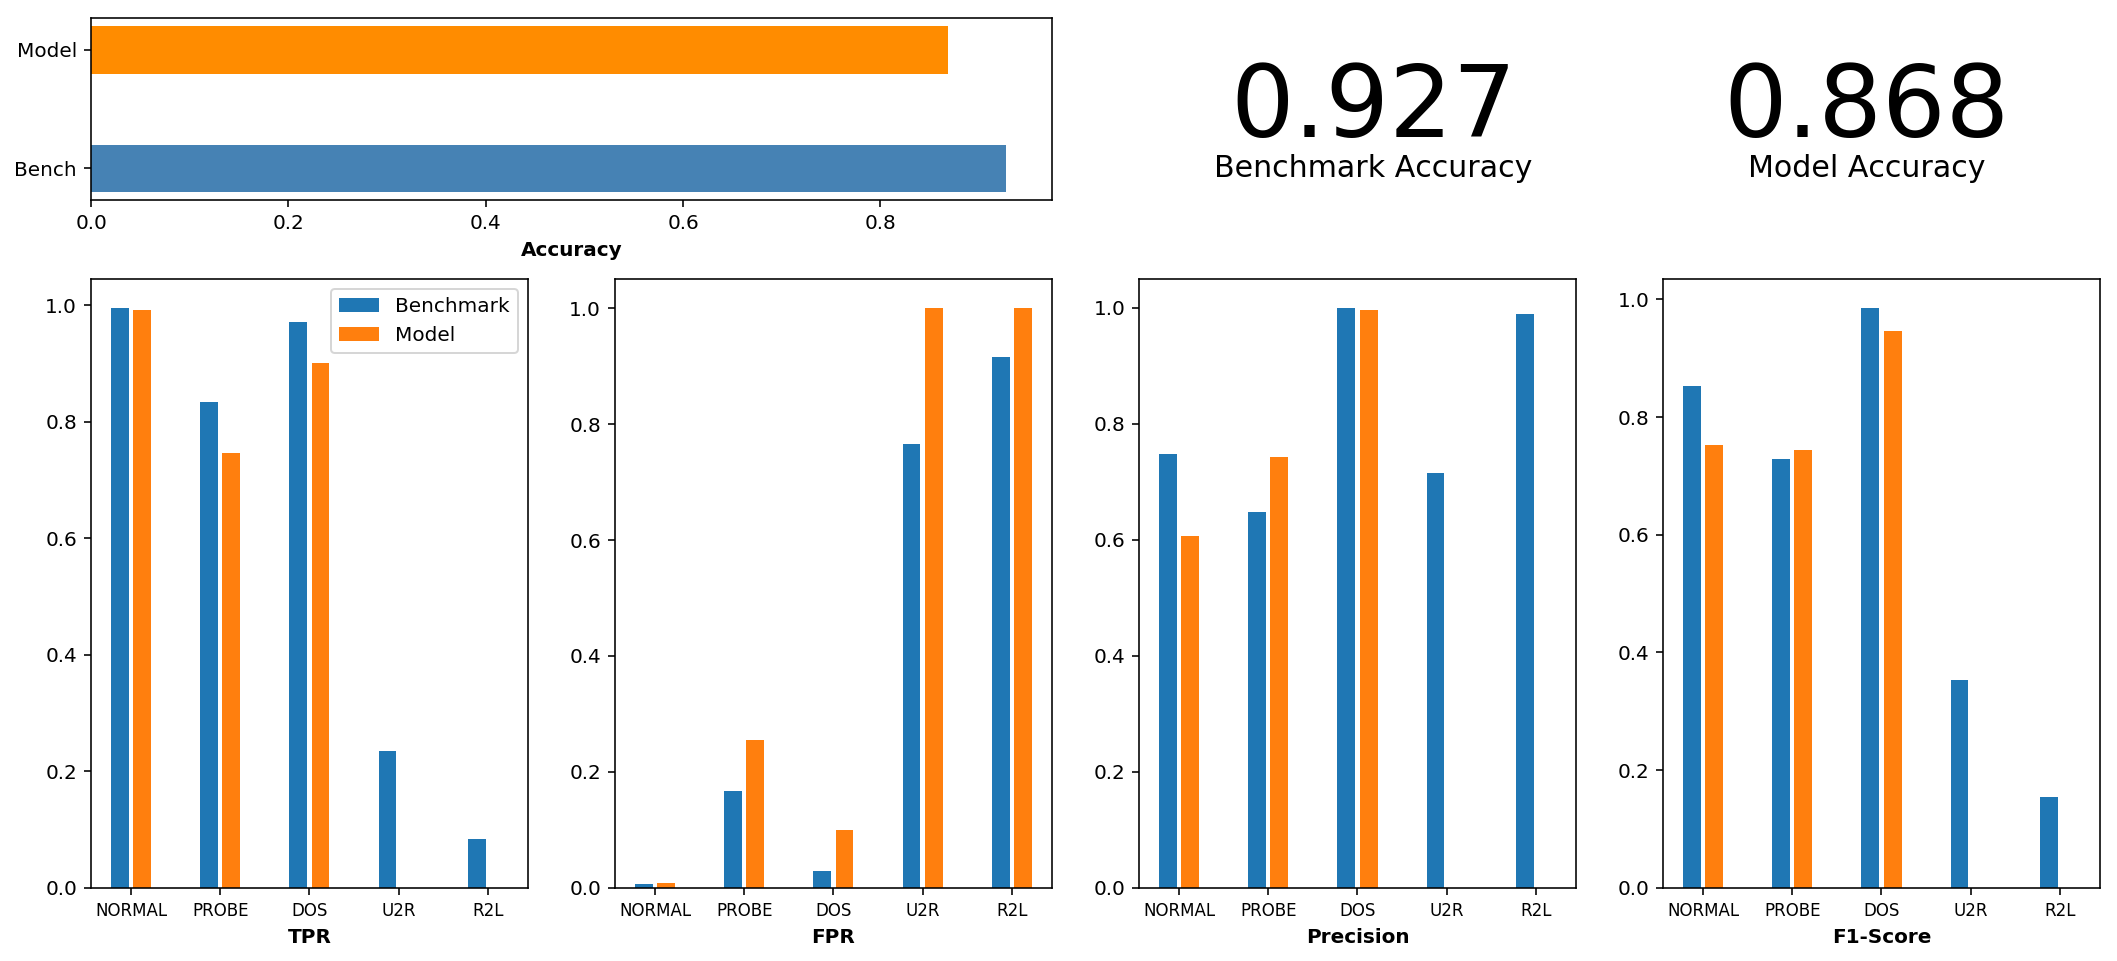

In [20]:
conf_bench = hm.getBenchmarkResults()
metrics = hm.computePerformanceMetrics(conf_bench, conf_matrix)
hm.plotMetrics(metrics)

